In [3]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.12.0
0.12.0


In [29]:
from IPython.display import Audio, display
import matplotlib
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")
        
def _get_sample(path, resample=None):
    effects = [
    ["remix", "1"]
    ]
    if resample:
        effects.extend([
          ["lowpass", f"{resample // 2}"],
          ["rate", f'{resample}'],
        ])
    return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, audio_path, resample=None):
    return _get_sample(audio_path, resample=resample)

def get_sample(*, audio_path, resample=None):
    return _get_sample(audio_path, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate

In [18]:
FILE = "/Users/fernando/Music/Ocean-AguaOneShotKit/Synths/Synth 1.wav"

In [19]:
waveform, sample_rate = torchaudio.load(FILE)

In [20]:
play_audio(waveform, sample_rate)

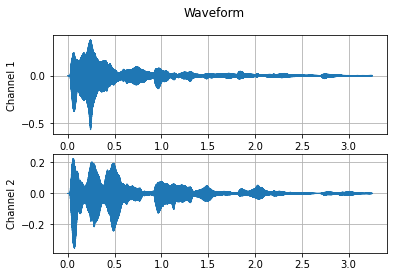

In [25]:
plot_waveform(waveform, sample_rate)

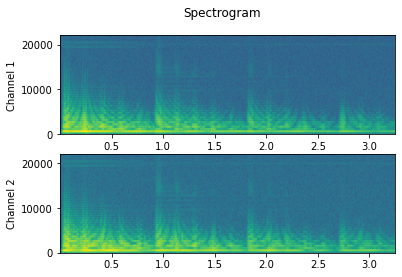

In [26]:
plot_specgram(waveform, sample_rate)

In [33]:
waveform

tensor([[-6.1035e-05, -9.1553e-05, -1.8311e-04,  ...,  3.7231e-03,
          3.7231e-03,  3.6621e-03],
        [-6.1035e-05, -9.1553e-05, -1.8311e-04,  ...,  1.1292e-03,
          7.9346e-04,  4.5776e-04]])

In [41]:
# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  #["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform, sample_rate, effects)

In [42]:
play_audio(waveform, sample_rate)
play_audio(waveform2, sample_rate2)

In [46]:
waveform2.shape

torch.Size([2, 143325])

In [47]:
import numpy as np

In [134]:
SHAPE = (1,2,44100)

x = np.linspace(0,1, 44100)
y = 0.8*np.sin(2*np.pi*220*x)
sin_tensor = torch.tensor(y)
sin_tensor = sin_tensor.reshape((1,44100))
clean_signal = torch.tensor([y,y]).reshape(SHAPE)

In [135]:
clean_signal[0].shape

torch.Size([2, 44100])

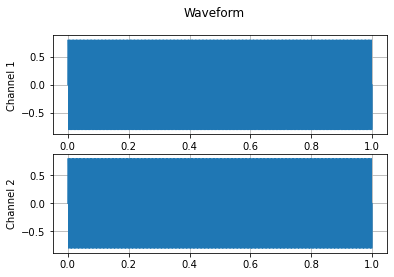

In [136]:
plot_waveform(clean_signal[0], 44100)
play_audio(clean_signal[0], 44100)

In [80]:
SHAPE

(1, 2, 44100)

In [120]:
def _apply_effects(audio_tensor, fs, block_size, n_channels, shape=(1, 2, 44100)):
    
    """
    Entrada: shape torch.Size([1, 2, 44100])
    Convertir con audio_tensor[0] --> torch.Size([2, 44100]) izq
    Convertir con audio_tensor[1] --> torch.Size([2, 44100]) derecha
    procesar
    convertir processed audio tensor torch.Size([1, 2, 44100])
        out_tensor_signal = torch.tensor([ch0,ch1]).reshape(shape)
    
    """
    
    # Define effects
    effects = [
      ["lowpass", "-1", "300"], # apply single-pole lowpass filter
      #["speed", "0.8"],  # reduce the speed
                         # This only changes sample rate, so it is necessary to
                         # add `rate` effect with original sample rate after this.
      ["rate", f"{fs}"],
      ["reverb", "-w"],  # Reverbration gives some dramatic feeling
    ]
    
    # raw_ch0 = audio_tensor[0][0]
    # raw_ch1 = audio_tensor[0][1]
    
    out_sig, _ = torchaudio.sox_effects.apply_effects_tensor(
        audio_tensor.reshape(n_channels, block_size).float(),
        fs, 
        effects
    )    
    
    return out_sig

In [121]:
out_sig = _apply_effects(clean_signal, 44100, 44100,2)

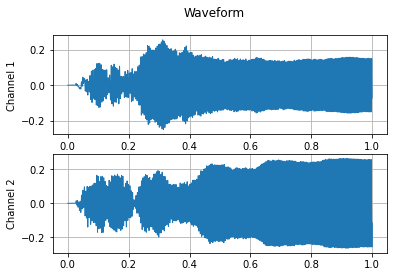

In [127]:
plot_waveform(out_sig, 44100)
play_audio(out_sig, 44100)

In [123]:
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F

In [131]:
class Effects(nn.Module):
    def __init__(self, fs: int, block_size: int, n_channels: int) -> None:
        super().__init__()
        self.fs = fs 
        self.block_size = block_size
        self.n_channels = n_channels
        
    @staticmethod
    def _apply_effects(audio_tensor, fs, block_size, n_channels, shape=(1, 2, 44100)):
        effects = [
          ["lowpass", "-1", "300"],
          ["rate", f"{fs}"],
          ["reverb", "-w"],
        ]

        out_sig, _ = torchaudio.sox_effects.apply_effects_tensor(
            audio_tensor.reshape(n_channels, block_size).float(),
            fs, 
            effects
        )    

        return out_sig
    
    
    def forward(self, x: Tensor) -> Tensor:
        x = self._apply_effects(x, self.fs, self.block_size, 2)
        return x

In [132]:
model = Effects(44100, 44100, 2)

In [133]:
clean_signal = torch.tensor([y,y]).reshape(SHAPE)
model.forward(clean_signal)


tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0639, -0.0681, -0.0723],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1303, -0.1232, -0.1160]])